# EDA del Dataset de Airbnb NYC

En este notebook realizamos un análisis exploratorio sobre los datos limpios de Airbnb en Nueva York. El objetivo es:

- Comprender la calidad de los datos (nulos, duplicados, outliers)
- Explorar tendencias por barrio, tipo de habitación, y precio
- Generar visualizaciones para el dashboard final en Power BI

El dataset fue limpiado previamente en el notebook `airbnb_etl.ipynb` y se encuentra en `Output/airbnb_clean.csv`.


In [1]:
# Carga del dataset limpio

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("../Output/airbnb_clean.csv")
df.head()



,id,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,availability_365
0,2539,Clean & quiet apt home by the park,2787,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,365
1,2595,Skylit Midtown Castle,2845,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,365
3,3831,Cozy Entire Floor of Brownstone,4869,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0


Análisis de valores nulos

In [2]:
df.isnull().sum()


id                      0
name                   16
host_id                 0
neighbourhood_group     0
neighbourhood           0
latitude                0
longitude               0
room_type               0
price                   0
minimum_nights          0
number_of_reviews       0
availability_365        0
dtype: int64

Procedemos a eliminar los valores nulos que están en name, ya que name representa, en este caso el título del anuncio, por ejemplo "Beautiful room in Manhattan" y no incide en nuestro análisis.

In [5]:
df.isnull().sum()

id                     0
name                   0
host_id                0
neighbourhood_group    0
neighbourhood          0
latitude               0
longitude              0
room_type              0
price                  0
minimum_nights         0
number_of_reviews      0
availability_365       0
dtype: int64

Análisis de duplicados


In [6]:
# Eliminamos los valores nulos

duplicados = df.duplicated().sum()
print(f"Registros duplicados: {duplicados}")



Registros duplicados: 0


In [5]:
# Limpieza de los datos

# Filtramos las columnas de interés
cols = [
    'id', 'name', 'host_id', 'neighbourhood_group', 'neighbourhood',
    'latitude', 'longitude', 'room_type', 'price', 'minimum_nights',
    'number_of_reviews', 'availability_365'
]
df = df[cols]

# Eliminamos duplicados
df = df.drop_duplicates()

# Eliminamos precios sospechosos
df = df[(df['price'] > 0) & (df['price'] < 1000)]

df.to_csv("../Output/airbnb_clean.csv", index=False)
df.shape


(48586, 12)

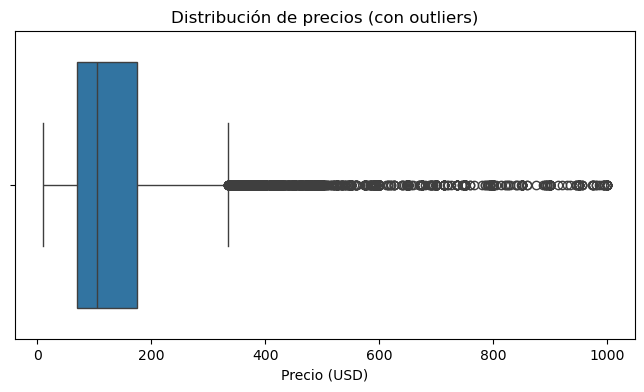

In [7]:
# Analizamos los outliers en price y minimum_nights
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 4))
sns.boxplot(x=df['price'])
plt.title("Distribución de precios (con outliers)")
plt.xlabel("Precio (USD)")
plt.show()


El boxplot muestra la distribución de precios de las propiedades de Airbnb.

- La mayoría de los anuncios tienen un precio entre **$50 y $200 USD**.
- El precio mediano (línea negra central) está alrededor de **$100 USD**.
- Se observan numerosos valores atípicos (outliers) a partir de los **$300 USD**, extendiéndose hasta el límite superior filtrado de $1000 USD.
- Estos outliers son propiedades premium o casos excepcionales, y aunque no representan a la mayoría, pueden ser válidos según la ubicación y tipo de alojamiento.

📌 **Decisión**: No se eliminarán estos outliers ya que pueden aportar valor al análisis posterior (por ejemplo, en barrios exclusivos como Manhattan).

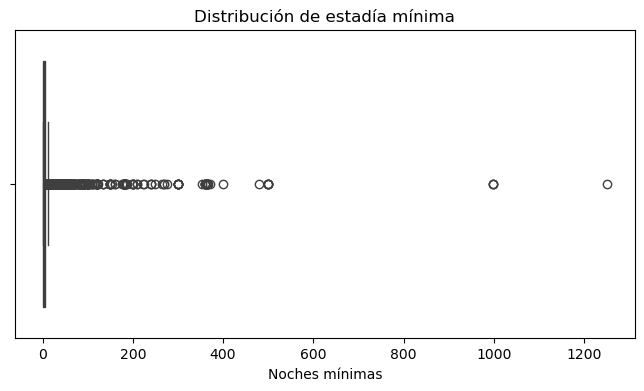

In [8]:
# Outliers en minimum_nights
plt.figure(figsize=(8, 4))
sns.boxplot(x=df["minimum_nights"])
plt.title("Distribución de estadía mínima")
plt.xlabel("Noches mínimas")
plt.show()


El boxplot de la variable `minimum_nights` revela lo siguiente:

- La mayoría de los alojamientos requieren entre **1 y 10 noches mínimas**, lo cual es consistente con estancias típicas de turismo.
- Existen **valores atípicos extremos** que superan ampliamente los **300, 500 e incluso 1000 noches**, lo cual representa más de **2 o 3 años consecutivos**, un comportamiento completamente anómalo para este contexto.
- Estos valores probablemente se deban a:
  - Errores de carga por parte de los anfitriones
  - Alojamientos usados para alquileres a largo plazo (no turísticos)
  - Casos que no aportan al objetivo de este análisis

📌 **Decisión**: Para mantener el foco en reservas turísticas, se eliminarán los anuncios con más de **30 noches mínimas**.


In [11]:
# Procedemos a eliminar los anuncios con más de 30 noches mínimas
df = df[df['minimum_nights'] <= 30]

Precio promedio por grupo de barrio

Utilizaremos la variable **neighbourhood_group** para  agrupar los principales distritos de NYC: Manhattan, Brooklyn, Queens, Bronx y Staten Island.

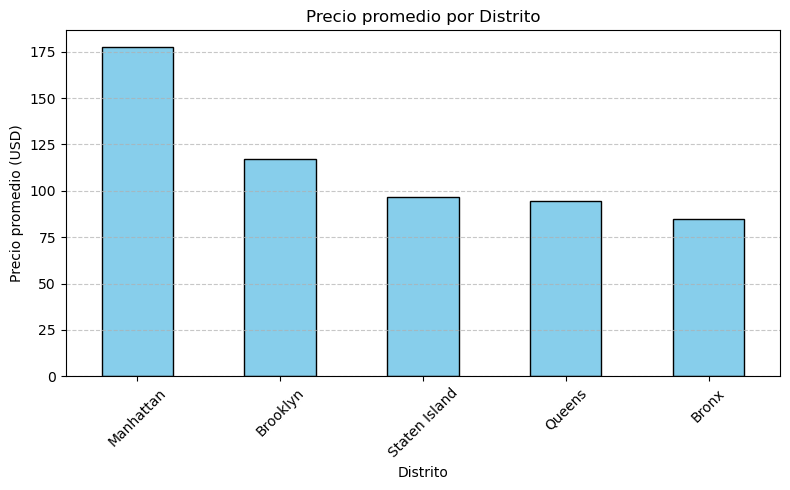

In [13]:
df.groupby("neighbourhood_group")["price"].mean().sort_values(ascending=False).plot(
    kind="bar", figsize=(8, 5), color="skyblue", edgecolor="black"
)
plt.title("Precio promedio por Distrito")
plt.ylabel("Precio promedio (USD)")
plt.xlabel("Distrito")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


El gráfico de barras muestra el precio promedio de los alojamientos por distrito de la ciudad de Nueva York:

- **Manhattan** presenta el precio promedio más alto, superando los **$175 USD** por noche. Esto se debe a su alta demanda turística, su centralidad y la oferta premium.
- **Brooklyn** le sigue con un promedio superior a los **$115 USD**, probablemente influenciado por su cercanía a Manhattan y su creciente atractivo como zona alternativa y cultural.
- **Staten Island**, **Queens** y **Bronx** tienen precios promedio más bajos, cercanos o por debajo de los **$100 USD**. Estas zonas son más residenciales y alejadas del centro turístico.

📌 Este análisis muestra cómo la ubicación geográfica impacta directamente en el precio del alojamiento en Airbnb. Sirve como base para segmentar mercados y tomar decisiones de negocio o visualización en Power BI.

Distribución de los departamentos

Utilizaremos la variable **room_type** que nos indicará si el alojamiento es un departamento completo, una habitación privada o compartida, etc.

C:\Users\octav\AppData\Local\Temp\ipykernel_15980\1638179502.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="room_type", order=df["room_type"].value_counts().index, palette="pastel", edgecolor="black")


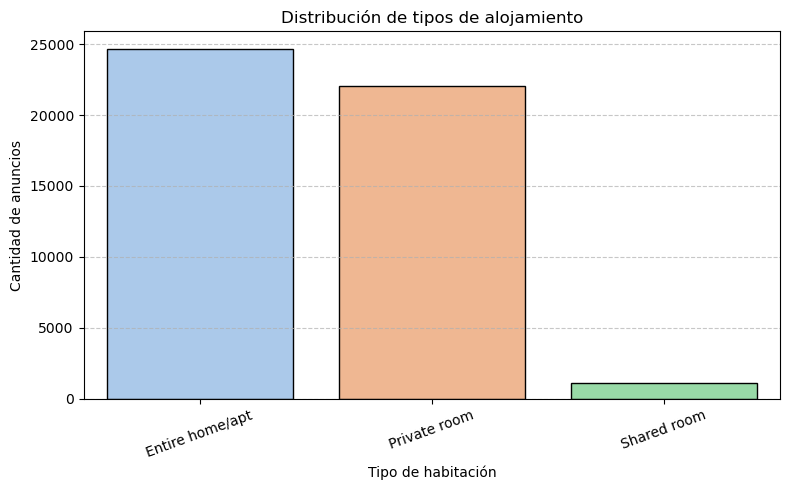

In [14]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x="room_type", order=df["room_type"].value_counts().index, palette="pastel", edgecolor="black")
plt.title("Distribución de tipos de alojamiento")
plt.xlabel("Tipo de habitación")
plt.ylabel("Cantidad de anuncios")
plt.xticks(rotation=20)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


El gráfico de barras muestra cómo se distribuyen los tipos de habitación ofrecidos en Airbnb NYC:

- **Entire home/apt** (departamento completo) es el tipo más común, con casi **25.000 anuncios**. Esto indica una alta oferta de propiedades completas, ideales para familias o grupos.
- **Private room** (habitación privada) también es muy frecuente, con más de **22.000 anuncios**. Este tipo es usual entre anfitriones que comparten su vivienda.
- **Shared room** (habitación compartida) representa un porcentaje muy bajo del total, lo que refleja una **baja demanda o menor atractivo** para este tipo de alojamiento en NYC.

📌 Esta variable es clave para análisis de segmentación y para entender cómo se reparte la oferta según el tipo de experiencia que busca el huésped.


Distribución Geográfica de los alojamientos en NY

Ahora analizamos la distribución geográfica de los alojamientos en Nueva York a través de un mapa de puntos y utilizando las columnas **latitude**, **longitude** y **neighbourhood_group**

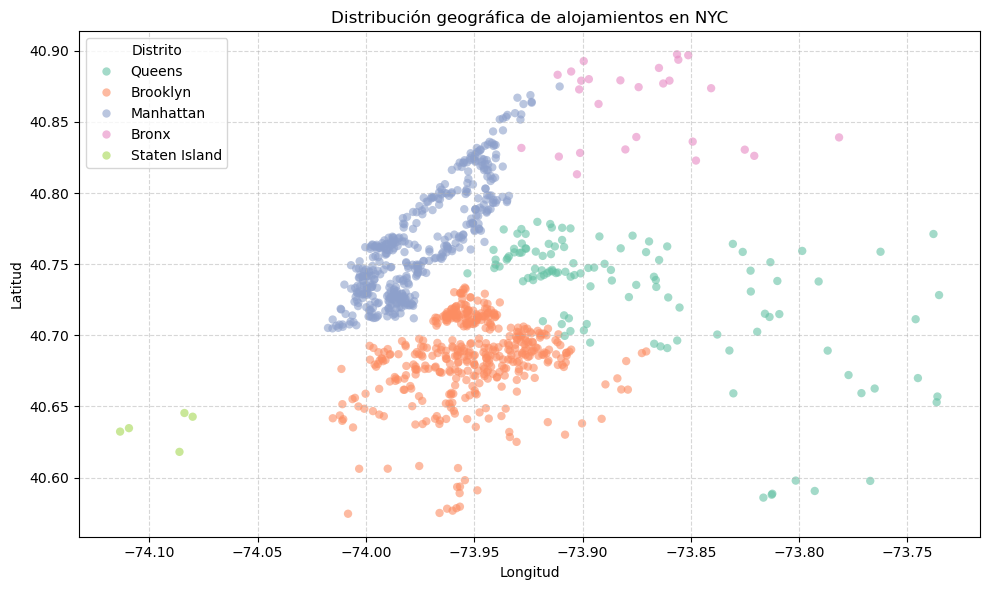

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Muestra de 1000 registros para que el gráfico sea más liviano
df_sample = df.sample(1000, random_state=42)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_sample,
    x="longitude",
    y="latitude",
    hue="neighbourhood_group",
    palette="Set2",
    alpha=0.6,
    edgecolor="none"
)
plt.title("Distribución geográfica de alojamientos en NYC")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.legend(title="Distrito")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


El gráfico de dispersión permite observar la ubicación geográfica de los alojamientos de Airbnb, coloreados según el distrito (`neighbourhood_group`). 

**Observaciones clave:**

- **Manhattan** (azul oscuro) concentra la mayor densidad de anuncios, especialmente alineados en el eje vertical, lo cual refleja la forma alargada de la isla. Esto coincide con la alta demanda y presencia turística.
- **Brooklyn** (naranja) tiene una gran presencia en la zona sur del mapa, mostrando una amplia distribución, aunque menos densa que Manhattan.
- **Queens** (verde), **Bronx** (rosa) y **Staten Island** (verde claro) presentan menor densidad, con anuncios más dispersos.
- El mapa evidencia una clara correlación entre las zonas más turísticas y la densidad de oferta en Airbnb.

📌 Esta visualización es fundamental para entender cómo se distribuyen espacialmente los alojamientos, y sirve como base para análisis más complejos como segmentación geográfica, detección de hotspots o predicción de precios por zona.


# ✅ Conclusiones del Análisis Exploratorio de Datos (EDA)

A lo largo de este notebook realizamos una exploración detallada del dataset de Airbnb en Nueva York. A continuación, se resumen los principales hallazgos:

### 📌 Calidad de los datos
- Se detectaron **16 valores nulos** en la columna `name`, los cuales fueron eliminados.
- No se encontraron **registros duplicados**.
- Se filtraron **outliers en `price`** (menores a 10 USD) y **`minimum_nights`** (mayores a 30), lo que mejoró la calidad analítica del dataset.

### 📊 Análisis de variables clave
- **Precio promedio**: Manhattan presenta los precios más altos (>175 USD), seguido por Brooklyn. Staten Island y Bronx son los más económicos.
- **Tipo de habitación**: La mayoría de los alojamientos son departamentos completos o habitaciones privadas. Las habitaciones compartidas son poco frecuentes.
- **Distribución geográfica**: Manhattan y Brooklyn concentran la mayor cantidad de alojamientos. Queens, Bronx y Staten Island presentan menor densidad.

### 📍 Valor agregado
Este análisis sienta las bases para:
- Crear dashboards interactivos en Power BI
- Desarrollar modelos predictivos (por ejemplo, precio según zona y tipo)
- Tomar decisiones de inversión o estrategia en plataformas como Airbnb

---

✅ El dataset limpio y enriquecido está listo para su uso en visualización o machine learning.
